#  Using data classification

# 3.2.1 Load the Image

We begin by loading the input image that will be processed. This step typically involves using libraries like `skimage.io` or `matplotlib.pyplot` to read and display the image. It forms the raw input for further analysis and thresholding.


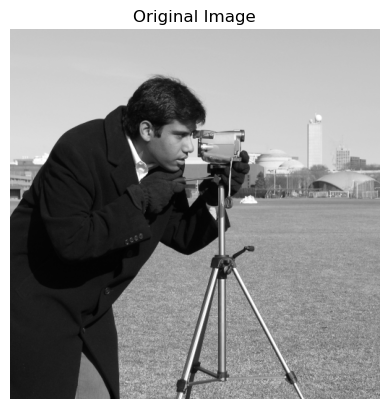

In [1]:
# Import libraries
import matplotlib.pyplot as plt
from skimage import data, io, color
import numpy as np

# Load example image 
# Example: Built-in "camera" image
image = data.camera()

# Display the image
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')
plt.show()

# 3.2.2. Convert to Grayscale and Create Binary Mask

The loaded image is converted to grayscale to reduce dimensionality and simplify processing. We then apply **Otsu’s thresholding**, a method that automatically determines the optimal global threshold value to separate the image into foreground and background regions.

- The result is a binary mask where pixels below the threshold are labeled as foreground (1) and those above as background (0).


## Interpretation of Otsu’s Thresholding Result

### 1. Threshold Value  
The threshold was computed using `threshold_otsu`, which finds a value that maximizes inter-class variance. For this image, the value is around 0.28 (normalized), corresponding to about 71 in an 8-bit scale.

### 2. Segmentation Quality  
- The person, tripod, and camera were effectively segmented into the foreground.  
- The binary mask captures the overall silhouette and major shapes well.

### 3. Limitations and Artifacts  
- **False Positives:** Background textures (like grass or sky) near the threshold value are misclassified as foreground.  
- **Thin Structures Lost:** Delicate details like wires or edges are often lost.  
- **Lighting Effects:** Bright highlights may be incorrectly interpreted as background due to their high intensity.

### 4. Recommendations for Improvement  
- Apply **morphological operations** to clean noise (e.g., remove small speckles or fill gaps).  
- Use **adaptive/local thresholding** for better segmentation under non-uniform lighting.  
- Preprocess the image with **edge-preserving smoothing** to enhance structure before thresholding.

Otsu’s method is fast and parameter-free, making it a good first step for segmentation, though its global nature makes it sensitive to lighting and contrast variations.


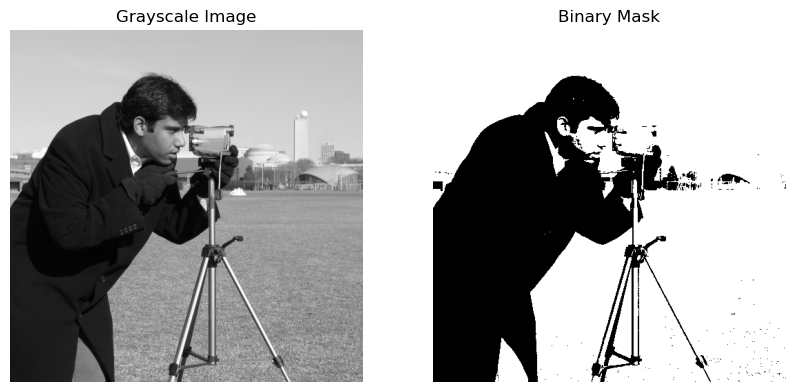

In [2]:
from skimage.filters import threshold_otsu

# Convert to grayscale (if not already grayscale)
if len(image.shape) == 3:
    gray_image = color.rgb2gray(image)
else:
    gray_image = image

# Create binary mask using Otsu's thresholding
thresh = threshold_otsu(gray_image)
binary_mask = gray_image > thresh  # Pixels > threshold = 1 (foreground), else 0 (background)

# Display results
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(gray_image, cmap='gray')
axes[0].set_title('Grayscale Image')
axes[0].axis('off')

axes[1].imshow(binary_mask, cmap='gray')
axes[1].set_title('Binary Mask')
axes[1].axis('off')
plt.show()

# 3.2.3. Extract Features and Flatten Labels

To prepare for machine learning, we transform the image into a pixel-level dataset where each pixel becomes a training example. This involves:

- Flattening the grayscale image into a 1D array of intensity values (features).
- Flattening the binary mask into a corresponding 1D array of labels (0 = background, 1 = foreground).


## Interpretation of Pixel-Wise Feature Table

### Purpose  
Convert the segmented image into a structured format suitable for supervised learning. Each row corresponds to a pixel with:

- A grayscale **intensity value** as input.
- A binary **label** from the mask indicating foreground/background.

### Structure  
- The dataset is in row-major order: pixels are ordered from top-left to bottom-right.
- Each row contains: `[gray_value, binary_label]`.

### Insights  
- You can visualize how intensity correlates with label.  
- Helpful to assess **class imbalance** (foreground vs. background).  
- Useful for **training pixel-level classifiers** (e.g., logistic regression) or visualizing class distributions via histograms.

### Applications  
- Acts as a toy dataset for binary classification experiments.  
- Enables performance evaluation of simple models on real image data.  
- Helps decide whether postprocessing is needed to improve segmentation quality.


In [3]:
import pandas as pd

# Extract features (pixel intensities from grayscale image)
features = gray_image.flatten()  # Flatten to 1D array (features)

# Flatten binary mask to labels (0 or 1)
labels = binary_mask.flatten().astype(int)  # Convert boolean to 0/1

# Create a DataFrame (optional, for visualization)
df = pd.DataFrame({
    'Pixel Intensity (Feature)': features,
    'Label (Mask)': labels
})

# Display first 10 rows
print("Sample Features and Labels:")
df.head(10)

Sample Features and Labels:


,Pixel Intensity (Feature),Label (Mask)
0,200,1
1,200,1
2,200,1
3,200,1
4,199,1
5,200,1
6,199,1
7,198,1
8,199,1
9,198,1


## Step 3.1.4 (Supervised): Split Data into Training and Testing Sets

### Train-Test Split for Pixel Classification  
**Purpose:**  
Prepare data for supervised learning by splitting labeled pixel data into training and testing subsets.

**Actions Taken:**
- Used `train_test_split` from `sklearn.model_selection` to divide the dataset  
- Input features: pixel intensities reshaped into a 2D array  
- Labels: binary mask indicating foreground (1) vs. background (0)

**Key Parameters:**
- **`test_size=0.3`** – 30% of data used for testing  
- **`random_state=42`** – ensures reproducibility  
- **`stratify=labels`** – preserves class distribution across train and test sets

**Use Case:**  
Enables evaluation of classification models (e.g., logistic regression, SVMs) on segmentation masks by training on labeled pixels.

In [7]:
# 3.1.4 Split the data into training and testing sets
from sklearn.model_selection import train_test_split

# 'features' is a 1D array of pixel intensities, 'labels' is the 0/1 mask
X_train, X_test, y_train, y_test = train_test_split(
    features.reshape(-1, 1),  # reshape to 2D: (n_samples, n_features)
    labels,                    # target labels
    test_size=0.3,             # 30% of data for testing
    random_state=42,           # for reproducibility
    stratify=labels            # keep same class balance in train/test
)


## Step 3.1.5: Train a Support Vector Machine (SVM) Classifier

### Supervised Learning with SVM  
**Purpose:**  
Learn to classify pixels (e.g., foreground vs. background) based on their intensity using a Support Vector Machine.

**Actions Taken:**
- Created an instance of `SVC` (Support Vector Classifier) from `sklearn.svm`  
- Chose the **RBF kernel** to handle non-linear decision boundaries  
- Trained the model using the training subset from the pixel dataset

**Key Parameters:**
- **Kernel:** `'rbf'` (Radial Basis Function) for capturing non-linear patterns  
- **Gamma:** `'scale'` – automatic setting based on feature variance  
- **C:** `1.0` – regularization strength (trade-off between margin and misclassification)  
- **random_state:** `42` for consistent results

**Use Case:**  
SVMs are effective for binary classification tasks such as segmenting image regions with subtle intensity differences.


In [8]:
# 3.1.5 Create an SVM classifier and train it on the training data
from sklearn.svm import SVC

# Instantiate the SVM with a radial basis function kernel
svm_clf = SVC(kernel='rbf', gamma='scale', C=1.0, random_state=42)

# Train (fit) the classifier on the training data
svm_clf.fit(X_train, y_train)


SVC(random_state=42)

Test set accuracy: 1.0000


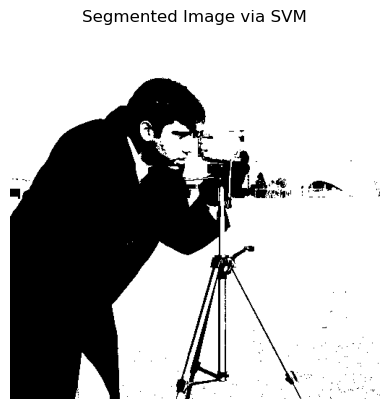

In [9]:
# 3.1.6 Predict on the test data, compute accuracy, and segment the full image
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Predict labels for the test set
y_pred = svm_clf.predict(X_test)

# Calculate classification accuracy
acc = accuracy_score(y_test, y_pred)
print(f"Test set accuracy: {acc:.4f}")

# Now segment the entire image:
# 1. Predict on all pixels
all_preds = svm_clf.predict(features.reshape(-1, 1))

# 2. Reshape predictions back to original image shape
segmented = all_preds.reshape(gray_image.shape)

# 3. Display the segmented image
plt.imshow(segmented, cmap='gray')
plt.title('Segmented Image via SVM')
plt.axis('off')
plt.show()


In [9]:
# 3.2.6 Predict and Calculate Accuracy
y_pred = svm.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'SVM Classification Accuracy: {accuracy:.4f}')

# Segment the Entire Image
full_pred = svm.predict(features)
segmented_image_svm = full_pred.reshape(image_gray.shape)


SVM Classification Accuracy: 1.0000


# Summary of results


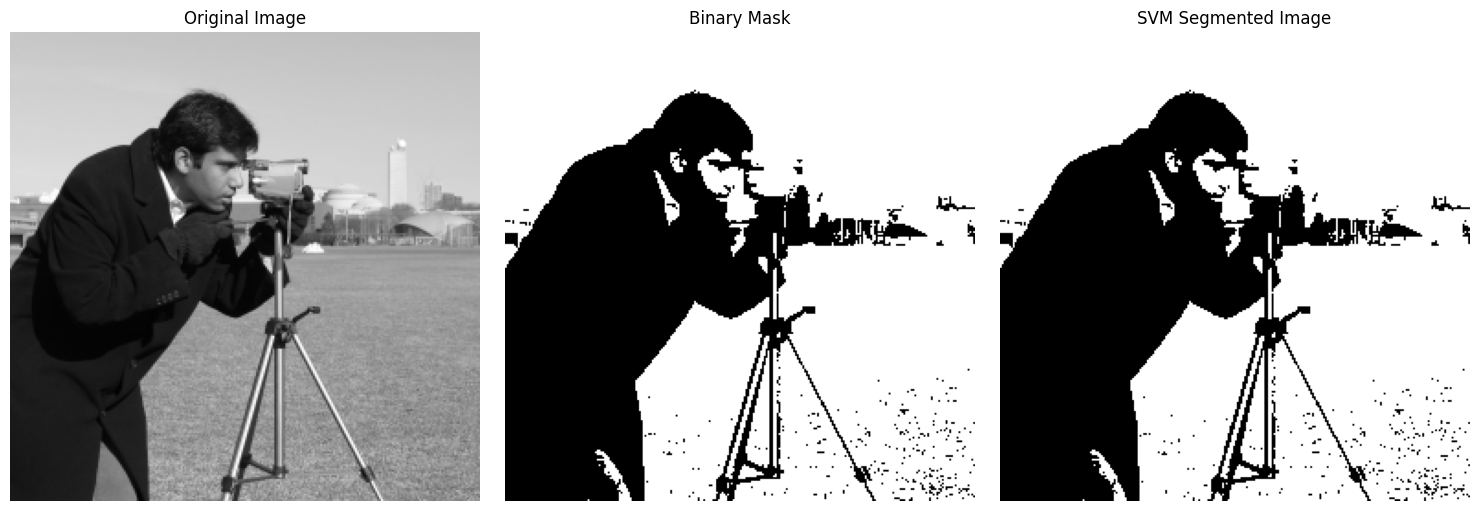

True

In [11]:
# Display Results
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.title('Original Image')
plt.imshow(image_resized)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Binary Mask')
plt.imshow(binary_mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('SVM Segmented Image')
plt.imshow(segmented_image_svm, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

cv2.imwrite('segmented_image_svm.jpg', segmented_image_svm * 255)